# The Rusunov splitting scheme for a compressible barotropic Navier-Stokes

In [1]:
from IPython.display import Latex

In this Script, we compute the solution of the <b>1D compressible barotropic Navier-Stokes</b> (<b> 1D CNS </b>) equation:

$$
\begin{aligned}
&\partial_t \rho + \partial_x (\rho u) = 0 & \forall (x,t) \in (0,1) \times \mathbb{R}^{+}\\
&\partial_t (\rho u) + \partial_x(\rho u^2 + p)  = \partial_x(\mu(\rho) \partial_x(u))& \forall (x,t) \in (0,1) \times \mathbb{R}^{+}\\
&p  = f(\rho) & \forall (x,t) \in (0,1) \times \mathbb{R}^{+}
\end{aligned}
$$
with a <b>periodic boundary condition</b>: 
$$ 
u(0) = u(1) \quad \text{and} \quad \rho(0) = \rho(1)
$$
We use a <b>Rusanov Scheme</b> for the spatial discretization and a <b>splitting method</b> for the time discretization.


Indeed, For the discrete model we use the following formulation of the model:
$$ 
\partial_t(U) + \partial_x(F(U)) = 0 \quad \forall (x,t) \in (0,1) \times \mathbb{R}^{+}
$$

<i>Before going into more theoritical details let us write some code:</i>

First we import the <b>Package fipy</b> which will help us to create different types of meshes on the domain

In [2]:
from fipy import *

The following packages are respectively for mathematical calculus, vizualizations and representations, handling sparse matrices, linear algebra on sparse matrices

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sp;
import scipy.sparse.linalg as splin;

The Package the <b>Toolbox</b> and <b>Diffusion1D</b> contains respectively, all the useful functions which will be used in the code 
and a function for constructing the Diffusion Matrix associated to the term: 
$$ \partial_x(\mu(\rho) \partial_x(u)) $$ 

In [4]:
from ToolBox import *
from Diffusion1D import *

<h1>Construction of the mesh<\h1>

We tell fipy to create a Periodic mesh. In fact the periodicity of the mesh is taken into account in the identification of the $\textbf{neighbouring}$ cells and faces. Of course the construction of a 1D mesh can be done by hand but we make this compromise in order be able to extend easily to higher dimensions (It will not be straightforward but easier).

In [5]:
L = 1.0
nx =100
dx = L / nx


# Construction du maillage
mesh = PeriodicGrid1D(dx, nx)


# Données du maillage
# Centres des mailles
x, = mesh.cellCenters

# Nombre de volumes, nombre de faces
nVol = mesh.numberOfCells
nFaces = mesh.numberOfFaces


# Faces associées aux cellules (en périodique)
FacesCells = mesh.faceCellIDs

Since we are working on the barotropic equation the pressure law is choosen as follows:
$$ p(\rho)=c \rho^{\gamma} $$

In [6]:
# Paramètre p(rho)=c*rho^{gamma}
c = 1.
gamma = 2.

***

<h1>Definition of the unkowns<\h1>

<b>fipy</b> allows us to compute the unknowns at specific positions in mesh (Faces or Centers). Thus, we can define $\textit{cell variables}$ and $\textit{face variables}$. As we said above, we will use the formulation: 
$$ 
\partial_t(U) + \partial_x(F(U)) = 0 \quad \forall (x,t) \in (0,1) \times \mathbb{R}^{+}
$$
In the following
<ul>
<li> $U1$ denotes the first component of $U$ and refers to the variable $\rho$ <\li>
<li> $U2$ denotes the second component of U and refers to the variable $\rho u$ <\li>
</ul>
<\ br>
They are both cell variables. In addition, we define two face variables called $Flux1$ and $Flux2$ which are registered on the cell faces.
By analogy to $U$, 
<ul>
<li> Flux1 denotes the first component of the convective Flux and refers to the discrete $\partial_x(\rho u)$ <\li>
<li> Flux2 denotes the second component of the convective Flux and refers to the discrete $\partial_x(\rho u^2 + p)$ <\li>
</ul>


In [7]:
# Variables
U1 = CellVariable(name='$u_1$', mesh=mesh, value=1., hasOld=True) #correspond à rho
U2 = CellVariable(name='$u_2$', mesh=mesh, value=0., hasOld=True) #correspond à rho*u, donnée initiale de la vitesse nulle
Flux1 = FaceVariable(name="\mathcal{F_1}", mesh=mesh, value=0.)
Flux2 = FaceVariable(name="\mathcal{F_2}", mesh=mesh, value=0.)

<h1> Initial Data </h1>

In [11]:
# Donnée initiale sur rho
U1.setValue(1., where=x >= 0.7)
U1.setValue(1., where=x < 0.5)
U1.setValue((np.sqrt(2.))**(1./gamma), where=(x > 0.5) & (x < 0.7))

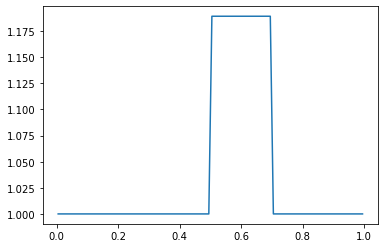

In [12]:
# Vizualize the initial data
plt.plot(x,U1.value)

In [10]:
# Donnée initiale sur rho
U1.setValue((np.sqrt(2.))**(1./gamma), where=x < 0.5)
U1.setValue(1., where=x > 0.5)

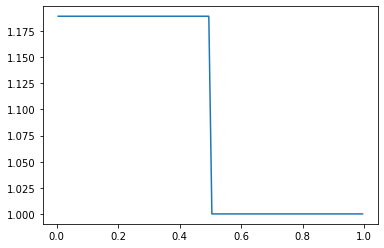

In [11]:
# Vizualize the initial data
plt.plot(x,U1.value)

<b>figures settings using fipy</b>

In [ ]:
# Paramètres graphiques
sp1, axes = plt.subplots(1, 2)

Rho = Matplotlib1DViewer(vars=U1, axes=axes[0], interpolation='spline16', figaspect='auto')

Rho_u_Rho = Matplotlib1DViewer(vars=U2/U1, axes=axes[1], interpolation='spline16', figaspect='auto')

viewers = MultiViewer(viewers=(Rho, Rho_u_Rho))

<b> Now we define some set of functions that will used for the numerical scheme </b>

In the following, the function <b>Fe</b> represents:
$$ Fe: (x_1,x_2) \mapsto 
\begin{pmatrix}
x_2\\
\dfrac{x_2^2}{x_1} + c x_1^\gamma
\end{pmatrix}$$
Where $x_1$ represents the variable $\rho$ and $x_2$ the variable $\rho u$. The function <b>Rusanov(U, dt, dx) </b>
takes as parameters the $U^{n}$, $dt$, $dx$ and compute $U^{n+1}$ by the <b> Rusanov method </b>. 

In [14]:
 #Rusanov
def Fe(x):
    return np.array([x[1], (((x[1]) ** 2) / x[0]) + c * (x[0]) ** gamma])

def Rusanov(U, lambda1, lambda2, max_lambdas, dt, dx):
    Flux1 = FaceVariable(name="\mathcal{F_1}", mesh=mesh, value=0.)
    Flux2 = FaceVariable(name="\mathcal{F_2}", mesh=mesh, value=0.)

    Flux = np.array([Flux1, Flux2])

    # Calcul du max des valeurs propres
    # lambda1 = np.abs((U2 / U1) - numerix.sqrt(c * gamma * (U1) ** (gamma - 1)))
    # lambda2 = np.abs((U2 / U1) + numerix.sqrt(c * gamma * (U1) ** (gamma - 1)))

    # Correction de Rusanov sur chaque faces
    # max_lambdas = numerix.maximum(numerix.maximum(lambda1[FacesCells[0]], lambda1[FacesCells[1]]),
    #                              numerix.maximum(lambda2[FacesCells[0]], lambda2[FacesCells[1]]))

    # Calcul du flux de Rusanov sur chaque faces
    tem_Flux = (centered_mean(Fe(U[:, FacesCells[0]]), Fe(U[:, FacesCells[1]])) - max_lambdas * (
    U[:, FacesCells[1]] - U[:, FacesCells[0]]) / 2.)  # Rusanov

    # tem_Flux = (centered_mean(Fe(U[:, FacesCells[0]]), Fe(U[:, FacesCells[1]])) -
    # (dx/dt) * (U[:, FacesCells[1]] - U[:, FacesCells[0]]) / 2.) #Lax-Friedrichs


    # Calcul du flux global
    Flux[0] = shiftg(tem_Flux[0]) - tem_Flux[0]
    Flux[1] = shiftg(tem_Flux[1]) - tem_Flux[1]

    Unew = U - (dt/dx)*Flux[:, 0:nFaces-1] #Mise à jour de U, Flux=[f0-f-1, f1-f0,....,f-1-f-2,f0-f-1], on coupe le dernier morceau

    U1.setValue(Unew[0])
    U2.setValue(Unew[1])

    return np.array([U1, U2])

To compute the <b> Diffusion matrix </b>, we need to compute the following functions. the function <b>mu_Rho</b> represents the term 
$\mu(\rho)$ appearing in the <b> Diffusion term </b>. For instance: 
$$ \mu: \rho \mapsto c \rho^{\alpha}$$
and the function <b>computes</b> the centered mean on $\mu(\rho)$ in order to get an approximation of $\mu(\rho)$ on the cell centers.

In [15]:
def mu_Rho(x,c):
    return c*x

def Phi_Rho(mu_Rho):
    if len(mu_Rho)==0:
        raise "Not a Vector"
    else:
        return (shiftg(mu_Rho) + mu_Rho)/2.

<h1>Computation of the hole CNS equation : Rusunov + Diffusion + Splitting in time </h1>

We start with choosing an initial time step (for instance 1e-2), this time step will be arranged by the <b>CFL Condition</b>
coming from the Rusanov part of the scheme

In [16]:
# Boucle en temps
dt1 = 1e-2
duration = 100
Nt = int(duration / dt1) + 1
dt = dt1
tps = 0.

Id = sp.lil_matrix(sp.spdiags(numerix.ones(nVol), [0], nVol, nVol))

In the time loop, we start with computing the eigenvalues of Jaccobian of $F(U)$, which are depicted as follows:
$$
\lambda_i = \left\vert \dfrac{x_2}{x_1} \right\vert + (-1)^i \sqrt{c \gamma x_1^{\gamma - 1}}, \quad i=1,2
$$
where $x_1$ represents $\rho$ and $x_2$ represents $\rho u$. 


In [18]:
while tps <= duration:

    if U1.value.any() < 0.:
        break
    U = np.array([U1, U2])

    # Masse
    M=dx*np.sum(U1.value)

    # Les valeurs propres
    lambda1 = np.abs((U2 / U1) - numerix.sqrt(c * gamma * (U1) ** (gamma - 1)))
    lambda2 = np.abs((U2 / U1) + numerix.sqrt(c * gamma * (U1) ** (gamma - 1)))

    # Correction de Rusanov sur chaque faces
    max_lambdas = numerix.maximum(numerix.maximum(lambda1[FacesCells[0]], lambda1[FacesCells[1]]),
                                  numerix.maximum(lambda2[FacesCells[0]], lambda2[FacesCells[1]]))

    # Etape Rusanov
    Ustar = Rusanov(U, lambda1, lambda2, max_lambdas, dt, dx)
    # Ustar=U
    mu_Rho_star = mu_Rho(Ustar[0], 1)
    phi_Rho_star = Phi_Rho(mu_Rho_star)

    # Matrice de Diffusion
    Diff = Build_Diffusion_Matrix(nVol, phi_Rho_star, dx)

    # Calcul du vecteur des vitesses dans la deuxieme etape du splitting
    U_ustar_new = splin.spsolve(Id - (dt/dx)*Diff, Ustar[1]/Ustar[0])

    # U_ustar_new = U
    U1.setValue(Ustar[0])
    U2.setValue(Ustar[0]*U_ustar_new)



    # Condition CFL
    dt = np.min([dt1, 0.8 * dx / (np.max(max_lambdas.value))])

    # Mise à jour du temps
    tps = tps + dt

    print('time:{0}, dt: {1}, M: {2}'.format(tps, dt, M))
    # if np.isnan(dt):
    #     break

    viewers.plot()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<it> if we take as initial condition, a square signal, we get in long time the profil in the previous curve </it>